# Master Project - 1. Milestone

### Exploration of Bandit Algorithms

Author: Marvin Ernst

Date: February 11, 2025

Importin relevant Libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. A Multi-Armed Bandit environment

In [2]:
class MultiArmedBandit:
    def __init__(self, k=5):
        """
        Initialize a multi-armed bandit problem with K arms.
        Each arm has a fixed (but unknown) reward probability.
        """
        self.k = k  # Number of arms
        self.true_means = np.random.rand(k)  # True (unknown) reward probabilities
    
    def pull_arm(self, arm):
        """Simulate pulling an arm, returning a reward (1 with probability true_means[arm], otherwise 0)."""
        return 1 if np.random.rand() < self.true_means[arm] else 0

### 2. Random policy for baseline comparison

In [3]:
class RandomPolicy:
    def __init__(self, k):
        self.k = k
    
    def select_arm(self):
        """Randomly select an arm."""
        return np.random.choice(self.k)

### 3. Thompson Sampling implementation

In [4]:
class ThompsonSampling:
    def __init__(self, k):
        """Thompson Sampling policy using Beta distributions."""
        self.k = k
        self.alpha = np.ones(k)  # Success counts
        self.beta = np.ones(k)   # Failure counts
    
    def select_arm(self):
        """Select an arm based on Thompson Sampling."""
        samples = [np.random.beta(self.alpha[i], self.beta[i]) for i in range(self.k)]
        return np.argmax(samples)
    
    def update(self, arm, reward):
        """Update the beta distribution parameters based on observed reward."""
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

### 4. Simulation with regret tracking and visualization

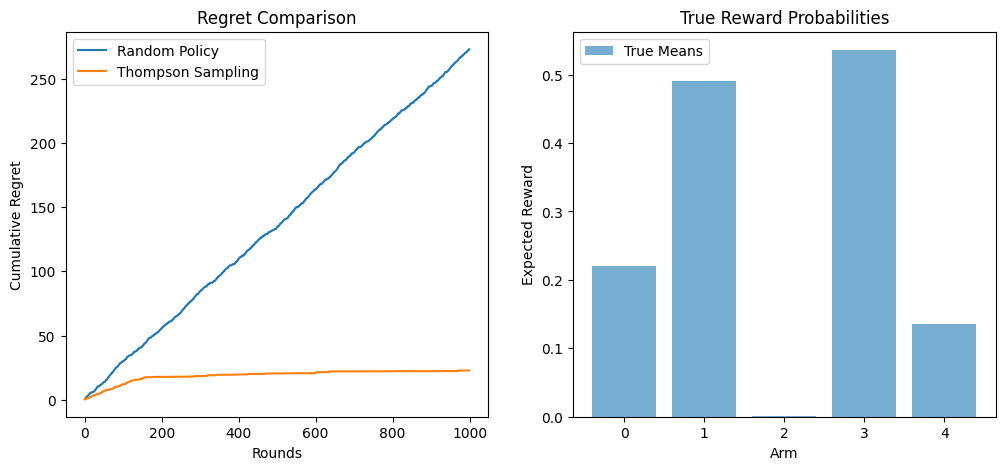

In [5]:
# Simulation parameters
k = 5  # Number of arms
n_rounds = 1000  # Number of pulls

# Initialize the bandit problem
bandit = MultiArmedBandit(k)
random_policy = RandomPolicy(k)
thompson_policy = ThompsonSampling(k)

# Track rewards and regret
random_rewards = []
thompson_rewards = []
optimal_reward = max(bandit.true_means)
random_regret = []
thompson_regret = []

# Run simulation
for _ in range(n_rounds):
    # Random Policy
    rand_arm = random_policy.select_arm()
    rand_reward = bandit.pull_arm(rand_arm)
    random_rewards.append(rand_reward)
    random_regret.append(optimal_reward - bandit.true_means[rand_arm])
    
    # Thompson Sampling Policy
    thompson_arm = thompson_policy.select_arm()
    thompson_reward = bandit.pull_arm(thompson_arm)
    thompson_policy.update(thompson_arm, thompson_reward)
    thompson_rewards.append(thompson_reward)
    thompson_regret.append(optimal_reward - bandit.true_means[thompson_arm])

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(random_regret), label='Random Policy')
plt.plot(np.cumsum(thompson_regret), label='Thompson Sampling')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.title('Regret Comparison')

plt.subplot(1, 2, 2)
plt.bar(range(k), bandit.true_means, alpha=0.6, label='True Means')
plt.xlabel('Arm')
plt.ylabel('Expected Reward')
plt.title('True Reward Probabilities')
plt.legend()
plt.show()

#### First Plot:

Random Policy (blue line):

•	The regret grows linearly over time, meaning that this policy is not learning which arms are better.

•	It continues to select suboptimal arms at a high rate, leading to increasing cumulative regret.

Thompson Sampling (orange line):

•	The regret plateaus quickly, which means it learns which arm is best and starts exploiting it.

•	This shows that Thompson Sampling effectively reduces regret compared to random selection.

Since the Thompson Sampling policy has significantly lower cumulative regret, it confirms that this approach outperforms random selection, as theory predicts.


#### Second Plot:

True Reward Probabilities (of each arm):

•	It looks like arms 1 and 3 have the highest expected rewards, meaning they are the “optimal” arms.

•	If the Thompson Sampling policy is working well, it should be selecting these arms more often over time.